In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

加算・乗算レイヤの実装

In [ ]:
class Add:
  def forward(self,x,y):
    return x+y
  def backward(self,dout):
    return (dout,)

In [ ]:
class Mul:
  def __init__(self):
    self.x = None
    self.y = None

  def forward(self,x,y):
    self.x = x
    self.y = y
    return x*y

  def backward(self,dout):
    dx = dout*self.y
    dy = dout*self.x
    return (dx,dy)
  

In [ ]:
#確認
mul_apple_num = Mul()
mul_orange_num = Mul()
add_both_price = Add()
mul_tax = Mul()
Layers_list = [mul_apple_num,mul_orange_num,add_both_price,mul_tax]
print(Layers_list[0])
print(mul_apple_num.forward(1,2))
dout = 1

apple_price = 200
orange_price = 100
apple_num = 2
orange_num = 3
tax = 1.2

apple_total = mul_apple_num.forward(apple_price,apple_num)
orange_total = mul_orange_num.forward(orange_price,orange_num)
both = add_both_price.forward(apple_total,orange_total)
total_price = mul_tax.forward(both,tax)

for i in [3,2,0]:
  dout = Layers_list[i].backward(dout)[0]


print(dout)  






活性化関数レイヤの実装

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))    


In [ ]:
#入力は行列
#Sigmoid
class Sigmoid:
  def __init__(self):
    self.out = None

  def forward(self,x):
    out = 1/(1+np.exp(-x))
    self.out = out
    return out

  def backward(self,dout):
    dx = dout*(1-self.out)*self*out
    return dx


In [ ]:
#Relu
class Relu:
  def __init__(self):
    self.mask = None
  def forward(self,x):
    self.mask = (x<=0)
    out = x.copy()
    out[self.mask] = 0
    return out

  def backward(self,dout):
    dout[self.mask] = 0
    return dout  


Affine レイヤの実装


In [ ]:
#入力は行列
class Affine:
  def __init__(self,w,b):
    self.w = w
    self.b = b
    self.db = None
    self.dw = None
    self.x = None

  def forward(self,x):
    self.x = x
    out = np.dot(x,self.w) + self.b
    return out

  def backward(self,dout):
    self.db = np.sum(dout,axis=0)
    self.dw = np.dot(self.x.T,dout)
    dx = np.dot(dout,self.w.T)
    return dx

In [ ]:
X = np.random.randn(100,50)
W = np.random.randn(50,10)
b = np.random.randn(10)
affine = Affine(W,b)
affine.forward(X)
dout = 1
dx = affine.backward(dout)
print(dx.shape)

Softmaxレイヤの実装

In [ ]:
def softmax(x):
  m = np.max(x,axis=1,keepdims = True)
  x = m - x
  return np.exp(x)/np.sum(np.exp(x),axis=1,keepdims=True)


SotmaxWithLossレイヤの実装

In [ ]:
def cross_entropy_error(y,t):
  if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
  if t.size == y.size:
      t = t.argmax(axis=1)
             
  batch_size = y.shape[0]
  return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


In [ ]:
class SoftmaxWithLoss:
  def __init__(self):
    self.y = None
    self.t = None
  def forward(self,x,t):
    y = softmax(x)
    self.y = y
    self.t = t
    return cross_entropy_error(y,t)

  def backward(self,dout=1):
    batch_size = self.t.shape[0]
    dx = (self.y-self.t) / batch_size
    return dx
    

誤差逆伝播を利用したNNの実装

In [ ]:
!git clone https://github.com/oreilly-japan/deep-learning-from-scratch.git

In [ ]:
import matplotlib.pyplot as plt 
import tensorflow as tf
from keras.utils.np_utils import to_categorical

mnist = tf.keras.datasets.mnist

def load_mnist(normalize = False, flatten = False, one_hot_label = False):
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  if (normalize):
    x_train = x_train / 255
    x_test = x_test / 255

  if (flatten):
    x_train = x_train.reshape(len(x_train), -1)
    x_test = x_test.reshape(len(x_test), -1)

  if (one_hot_label):
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)


  return (x_train,y_train), (x_test,y_test)

In [59]:
class TwoLayerNet:
  def __init__(self,weight_init_std = 0.01,input_size = 784,middle_size=50,output_size=10):
  #====インスタンスを格納してください====
    self.weight_init_std = weight_init_std
    self.input_size = input_size
    self.middele_size = middle_size
    self.output_size = output_size
    self.params = {}
    self.layers = OrderedDict()

   #ハイパーパラメータを渡してください
   #パラメータDictを保持してください
   #パラメータ初期値は、重みW1,W2: 標準偏差=weight_init_std の正規分布に設定してください
                #バイアスb1,b2: ゼロ行列に設定してください
    self.params['w1'] = weight_init_std*np.random.randn(input_size,middle_size)
    self.params['w2'] = weight_init_std*np.random.randn(middle_size,output_size)
    self.params['b1'] = np.zeros(middle_size)
    self.params['b2'] = np.zeros(output_size)

    self.layers['Affine1'] = Affine(self.params['w1'],self.params['b1'])
    self.layers['Relu'] = Relu()
    self.layers['Affine2'] = Affine(self.params['w2'],self.params['b2'])
    
    self.lastlayer = SoftmaxWithLoss()

  #=================================

  #必要な関数（スライド参照）を定義してください
  def predict(self,x):
      for layer in self.layers.values():
        x = layer.forward(x)

      return x

  def loss(self,x,t):
      y = self.predict(x)
      lost = self.lastlayer.forward(y,t)  
      return lost

  def numerical_grad(self,x,t):
      loss = lambda w: self.loss(x,t)
      grads = {}
      grads['w1'] = numerical_grad(loss,self.params['w1'])
      grads['w2'] = numerical_grad(loss,self.params['w2'])
      grads['b1'] = numerical_grad(loss,self.params['b1'])
      grads['b2'] = numerical_grad(loss,self.params['b2'])

      return grads

  def gradient(self):
      #forward
      # backward
      grads = {}
      dout = 1
      dout = self.lastlayer.backward(dout)

      layers_list = list(self.layers.values())
      layers_list.reverse()

      for layer in layers_list:
        dout = layer.backward(dout)

      grads['w1'] = self.layers['Affine1'].dw
      grads['b1'] = self.layers['Affine1'].db 
      grads['w2'] = self.layers['Affine2'].dw
      grads['b2'] = self.layers['Affine2'].db

      return grads

  def accuracy(self,x,t):
      y = self.predict(x)
      y = np.argmax(y, axis=1)
      if t.ndim != 1:
        t = np.argmax(t, axis=1)
      accuracy = np.sum(y == t) / x.shape[0]
      return accuracy 

In [65]:
np.random.seed(0)
epochs = 10
train_size = 10000
batch_size = 100
learning_rate = 0.01
NN = TwoLayerNet(input_size = 784,middle_size=50,output_size=10)


#====データをロードしてください====
(x_train,t_train),(x_test,t_test) = load_mnist(normalize=True,flatten=True,one_hot_label=True)
train_loss_list = []
train_acc_list = []
test_acc_list = []
iters_per_epoch = train_size//batch_size
#学習
for epoch in range(epochs):
  for iter in range(iters_per_epoch):
    #====スライドに従って学習を行ってください====
    #バッチ抽出
    batch_mask = np.random.choice(train_size,batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    lost = NN.loss(x_batch,t_batch)
    grads = NN.gradient()
    NN.params['w1'] -= learning_rate*grads['w1']
    NN.params['b1'] -= learning_rate*grads['b1']
    NN.params['w2'] -= learning_rate*grads['w2']
    NN.params['b2'] -= learning_rate*grads['b2']

    
    #======================================
    
  #====途中過程をtrain_loss_list,train_acc_list,test_acc_listに格納してください====
  
  train_loss_list.append(lost)
  train_acc = NN.accuracy(x_train,t_train)
  test_acc = NN.accuracy(x_test,t_test)
  train_acc_list.append(train_acc)
  test_acc_list.append(test_acc)
  print('======= epoch'+str(epoch)+'=======')
  print('Loss:',lost)
  print('train_acc:',train_acc)
  
  

======= epoch0=======
Loss: 2.297384289431641
train_acc: 0.23195
======= epoch1=======
Loss: 2.2852615185361196
train_acc: 0.4338666666666667
======= epoch2=======
Loss: 2.270966475908484
train_acc: 0.5089
======= epoch3=======
Loss: 2.2087076454372667
train_acc: 0.49246666666666666
======= epoch4=======
Loss: 2.112721428792286
train_acc: 0.50895
======= epoch5=======
Loss: 1.9282097322520904
train_acc: 0.5354
======= epoch6=======
Loss: 1.750170848033735
train_acc: 0.6013166666666667
======= epoch7=======
Loss: 1.3825589470347373
train_acc: 0.65035
======= epoch8=======
Loss: 1.219999916571547
train_acc: 0.7103833333333334
======= epoch9=======
Loss: 0.9717087920081263
train_acc: 0.7477166666666667


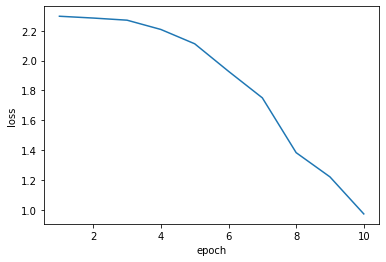

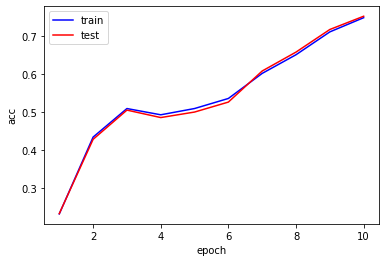

In [66]:
x = np.arange(1,epochs+1)

plt.plot(x,train_loss_list)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.plot(x,train_acc_list,'b',label='train')
plt.plot(x,test_acc_list,'r',label='test')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.show()

In [40]:
#関数の定義
def softmax(x):
    m = np.max(x,axis = -1,keepdims = True)
    return np.exp(x-m)/np.sum(np.exp(x-m)+1e-7,axis = 1,keepdims = True)

def cross_entropy_error(y,t):
    return -np.sum(t*np.log(y))/t.shape[0]

def sigmoid(x):
    return 1/(1+np.exp(-x))

def numerical_gradient(f,x,h= 1e-4):
    grad = np.zeros_like(x)
    h = 1e-4
    i = x.shape[0]
    if x.ndim == 2:
        j = x.shape[1]
    else:
        j = 0    
    x.flatten()
    for k in range(len(x)):
        idx = x[i]
        x[i]= idx + h
        f1x = f(x)
        x[i] = idx-h
        f2x = f(x)
        grad[i] = (f1x - f2x) / (2*h)
        x[i] = idx

    if j != 0:
        grad.reshape(i,j)
    
    return grad   


#レイヤの定義
class Affine:
    def __init__(self,w,b):
        self.w = w
        self.b = b
        self.x = None
        self.dw = None
        self.db = None

    def forward(self,x):
        self.x = x
        out = np.dot(x,self.w)+self.b
        return out

    def backward(self,dout):
        self.dw = np.dot(self.x.T, dout)
        dx = np.dot(dout,self.w.T)
        self.db = np.sum(dout,axis = 0)
        return dx

class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self,x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self,dout):
        dx = dout*(1-self.out)*self.out
        return dx   

class Relu:
    def __init__(self):
        self.mask = None
    def forward(self,x):
        self.mask = (x <= 0)   
        out = x.copy() #xの変更に伴ってself.maskが変更されてしまうのを防ぐ
        out[self.mask] = 0        
        return out      
    def backward(self,dout):
        dout[self.mask] = 0
        dx = dout
        return dx    


class SoftmaxWithLoss:
    def __init__(self):
        self.y = None
        self.t = None

    def forward(self,x,t):
        self.t = t
        y = softmax(x)
        self.y = y
        out = cross_entropy_error(y,t)
        return out

    def backward(self,dout):
        dx = (self.y - self.t)/self.t.shape[0]
        return dx

#最適化手法の定義
class SGD:
    def __init__(self,lr = 0.01):
        self.lr = lr

    #パラメータの更新    
    def upgrade(self,params,grads):
        for key in params.keys():
            params[key] -= self.lr*grads[key]


        

#誤差逆伝播のニューラルネット
class TwoLayorNet:
    def __init__(self,input_size,hidden_size,output_size,weight_init_std = 0.01):
        #パラメータを保持
        self.params = {}
        self.params['w1'] = np.random.randn(input_size,hidden_size)*weight_init_std
        self.params['b1'] = np.zeros(hidden_size)
        self.params['w2'] = np.random.randn(hidden_size,output_size)*weight_init_std
        self.params['b2'] = np.zeros(output_size)

        #レイヤを保持
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['w1'],self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['w2'],self.params['b2'])
        
        self.lastLayer = SoftmaxWithLoss()

    def predict(self,x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self,x,t):
        y = self.predict(x)
        lost = self.lastLayer.forward(y,t)        
        return lost

    def loss_with_weight_decay(self,x,t):
        loss = self.loss(x,t)
        weight = 0
        for param in self.params.keys():
            weight += (0.1*np.sum(self.params[param]**2))/2
        return loss + weight    

    def numerical_gradients(self,x,t):
        loss_w = lambda w: self.loss(x,t)
        grads = {}
        for key in self.params.keys():
            grads[key] = numerical_gradient(loss_w,self.params[key])

        return grads

    def gradient(self,x,t,weight_decay=False):
        layers = list(self.layers.values())
        layers.reverse()
        dout = 1
        dout = self.lastLayer.backward(dout)
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        if weight_decay:
            grads['w1'] = self.layers['Affine1'].dw+self.params['w1']*0.1
            grads['b1'] = self.layers['Affine1'].db
            grads['w2'] = self.layers['Affine2'].dw+self.params['w2']*0.1
            grads['b2'] = self.layers['Affine2'].db
        else:
            grads['w1'] = self.layers['Affine1'].dw
            grads['b1'] = self.layers['Affine1'].db
            grads['w2'] = self.layers['Affine2'].dw
            grads['b2'] = self.layers['Affine2'].db


        return grads

    def accuracy(self,x,t):
        y = self.predict(x)
        p = np.argmax(y,axis = 1)
        if t.ndim != 1:
            t = np.argmax(t,axis = 1)
        return np.sum(p==t)/t.shape[0]  



#データセットの準備
(x_train,t_train),(x_test,t_test) = load_mnist(normalize = True,one_hot_label=True)
train_size = x_train.shape[0]
batch_size = 100
epochs = 10
iters_per_epoch = train_size//batch_size
optimizer = SGD(lr=0.01)
network = TwoLayorNet(input_size = 784,hidden_size = 50, output_size=10)
train_loss_list = []
train_acc_list = []
test_acc_list = []

#学習
for epoch in range(epochs):
    for iter in range(iters_per_epoch):
        #バッチの生成
        batch_mask = np.random.choice(train_size,batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        #勾配の取得
        lost = network.loss(x_batch,t_batch)
        grads = network.gradient(x_batch,t_batch)

        #最適化手法の実行
        optimizer.upgrade(network.params,grads)


    #精度検証
    acc_train = network.accuracy(x_train,t_train)
    acc_test = network.accuracy(x_test,t_test)
    print('epoch:',epoch,'accuracy_train:',acc_train,'accuracy_test:',acc_test)
    train_acc_list.append(acc_train)
    test_acc_list.append(acc_test)
    train_loss_list.append(lost)


#描画
plt.plot(train_loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

plt.plot(train_acc_list,'b')
plt.plot(test_acc_list,'r') 
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()   
plt.show()
    


ValueError: shapes (100,28,28) and (784,50) not aligned: 28 (dim 2) != 784 (dim 0)